In [1]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [2]:
import sqlite3
conn = sqlite3.connect('../db.sqlite3')
cur = conn.cursor()
restaurant_order = pd.read_sql_query('SELECT * FROM restaurant_order', conn)
cur.execute('SELECT * FROM restaurant_order')
restaurant_orderitem = pd.read_sql_query('SELECT * FROM restaurant_orderitem', conn)
restaurant_product = pd.read_sql_query('SELECT * FROM restaurant_product', conn)
merged_df = pd.merge(restaurant_order, restaurant_orderitem, on='id')
merged_df = pd.merge(merged_df, restaurant_product, on='id')
merged_df.to_csv('merged_data.csv', index=False)
df = pd.read_csv('merged_data.csv')
conn.close()

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

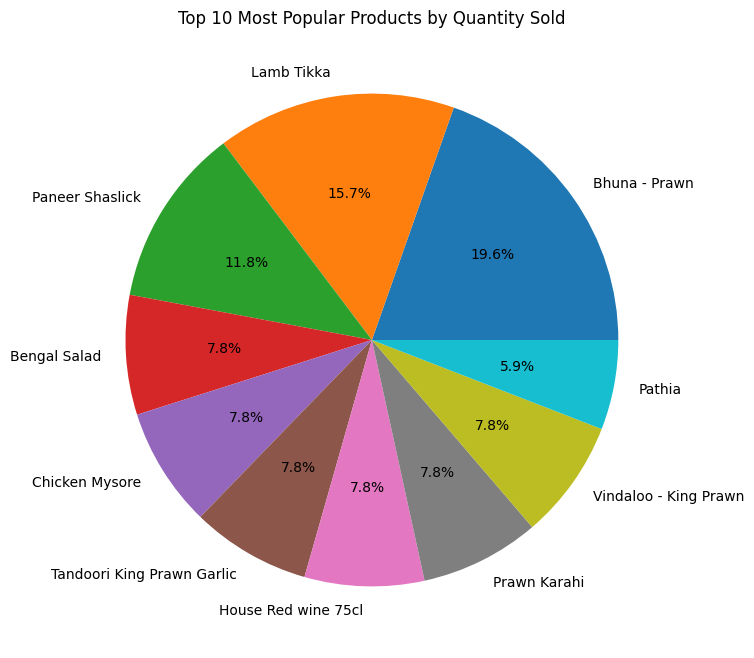

In [3]:
import matplotlib.pyplot as plt
product_sales = merged_df.groupby('name')['quantity'].sum()
top_10_products = product_sales.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 8))
plt.pie(top_10_products, labels=top_10_products.index, autopct='%1.1f%%')
plt.title('Top 10 Most Popular Products by Quantity Sold')
plt.show()
conn.close()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

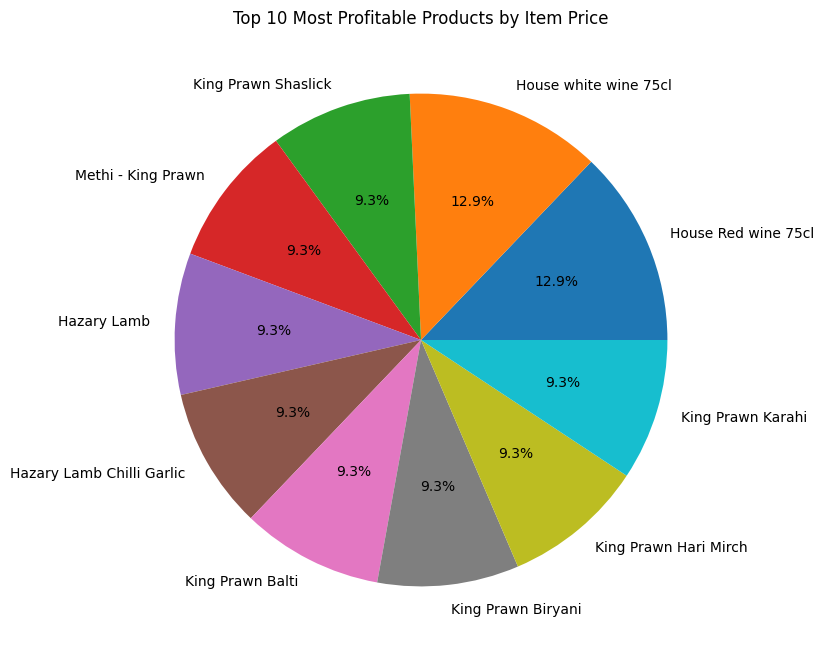

In [5]:
import sqlite3

conn = sqlite3.connect('db.sqlite3')
product_sales = merged_df.groupby('name')['price'].sum()
top_10_products = product_sales.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 8))
plt.pie(top_10_products, labels=top_10_products.index, autopct='%1.1f%%')
plt.title('Top 10 Most Profitable Products by Item Price')
plt.show()
conn.close()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

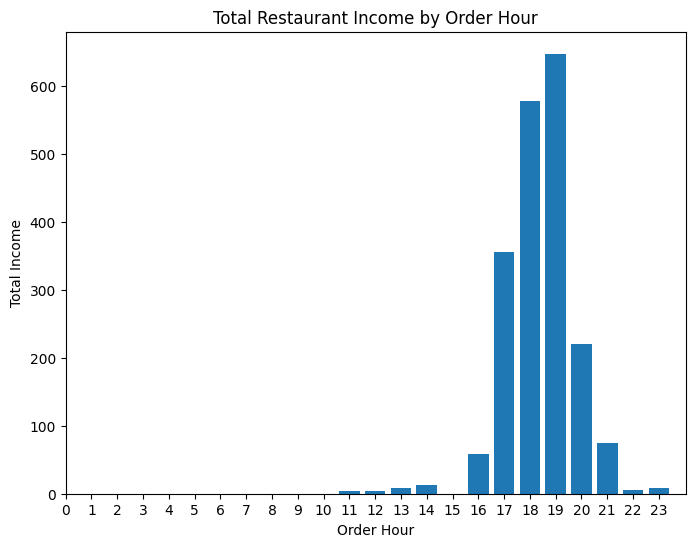

In [6]:
merged_df['order_hour'] = pd.to_datetime(merged_df['datetime']).dt.hour
order_hour_income = merged_df.groupby('order_hour')['price'].sum()
plt.figure(figsize=(8, 6))
plt.bar(order_hour_income.index, order_hour_income.values)
plt.xticks(np.arange(24))
plt.xlabel('Order Hour')
plt.ylabel('Total Income')
plt.title('Total Restaurant Income by Order Hour')
plt.show()
conn.close()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

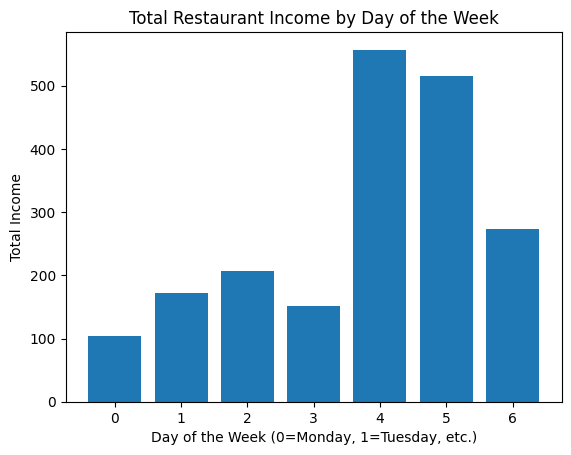

In [7]:
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df['day_of_week'] = merged_df['datetime'].dt.dayofweek
income_by_day = merged_df.groupby('day_of_week')['price'].sum()
plt.bar(income_by_day.index, income_by_day.values)
plt.title('Total Restaurant Income by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 1=Tuesday, etc.)')
plt.ylabel('Total Income')
plt.show()
conn.close()